In [1]:
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from numpy.linalg import inv
from scipy.stats import multivariate_normal
from jax import hessian
from jax import random
import jax.numpy as jnp

In [2]:
x = jnp.array([9.589, 7.375, 4.647, 2.501, 2.538, 6.783, 4.294, 5.111, 0.130, 0.783])
y = jnp.array([3.032, 3.349, 2.906, 2.126, 1.538, 2.787, 3.078, 2.993, 0.828, -0.331])

N = 10

def normal_dist(x, mu, sigma):
    return (1 / (jnp.sqrt(2 * jnp.pi) * sigma)) * jnp.exp(-0.5 * ((x - mu) / sigma) ** 2)

# gaussian prior
tau = 2
prior = lambda w : jnp.prod(normal_dist(w, 0, tau))
log_prior = lambda w : jnp.sum(jnp.log(normal_dist(w, 0, tau)))

sigmoid = lambda x : 1 / (1 + jnp.exp(-x))
f = lambda x, w : w[1] * sigmoid(x + w[0])

# noise variance
beta = 4

# gaussian likelihood
likelihood = lambda y, x, w: jnp.prod(normal_dist(y, f(x, w), jnp.sqrt(1/beta)))
log_likelihood = lambda y, x, w: jnp.sum(jnp.log(normal_dist(y, f(x, w), jnp.sqrt(1/beta))))

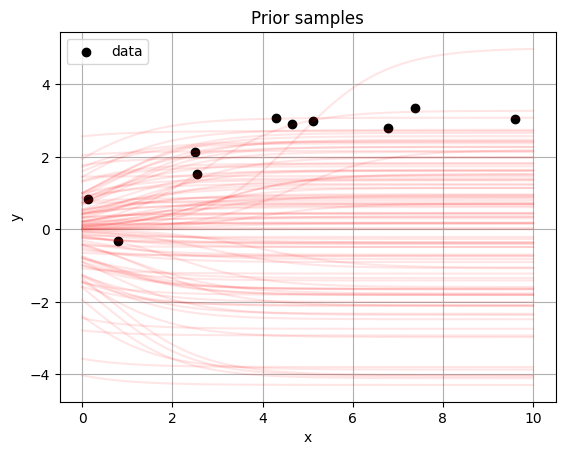

In [3]:
# Task 2.1

S = 100

# gaussian priors imposed on w
key = random.PRNGKey(42)
w_samples = random.normal(key, shape=(S, 2)) * tau
x_plot = jnp.linspace(0, 10, S)

for w in w_samples:
    y_plot = f(x_plot, w)
    plt.plot(x_plot, y_plot, 'r', alpha=0.1)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Prior samples')
plt.scatter(x, y, label='data', color='black')
plt.legend(loc='upper left')
plt.grid()
plt.show()

**Task 2.2**

We cannot use the closed form expression in Section 3.3 of Murphy to compute the posterior $p(w|y)$ for the neural network model.

$$
f(x) = w_1 \cdot \sigma(x+w_0)
$$

The assumptions used in Section 3.3 are that the model is linear in parameters w, and that the model is conjugate, i.e. the likelihood and prior are both gaussian, meaning that the posterior is also gaussian. The prior and likelihood must combine mathematically in a way that the posterior is the same family of distribution as the prior and likelihood. Thus, the parameters that enter the likelihood must preserve the structure (in this case linearly). However, the neural network model is not linear in parameters w because of the sigmoid function, thus the likelihood is not conjugate with respect to the prior, and the posterior is intractable.

Instead, we use the variational approximation to compute the posterior $p(w|y)$.

In [4]:
# Task 2.3

# joint density p(y, w)
log_joint = lambda w : log_prior(w) + log_likelihood(y, x, w)

log_joint(w = jnp.array([0., 0.]))

Array(-130.94936, dtype=float32)

In [5]:
# Task 2.4

grad_log_joint = lambda w : - (w/tau**2) + jnp.array([
    beta * jnp.sum( (y-w[1]*sigmoid(x+w[0])) * w[1] * sigmoid(x+w[0]) * (1-sigmoid(x+w[0]))),
    beta * jnp.sum( (y-w[1]*sigmoid(x+w[0])) * sigmoid(x+w[0]))
]) 


# hessian function using jax
H = hessian(log_joint)

print(H(jnp.array([0., 0.])))

# Symbolic hessian
def H(w):
    # Unpack parameters from w
    w0, w1 = w[0], w[1]
    
    # Compute the sigmoid values and its derivative with respect to (x + w0)
    s = sigmoid(x + w0)       # vector of sigmoid evaluations
    ds = s * (1 - s)          # derivative: s*(1-s)
    
    # Hessian element H00
    H00 = -1/tau**2 + beta * jnp.sum(
             -w1**2 * (ds**2) + w1 * (1 - 2*s) * ds * (y - w1*s)
          )
    
    # Hessian element H01 (and H10 since Hessian is symmetric)
    H01 = beta * jnp.sum(ds * (y - 2*w1*s))
    
    # Hessian element H11
    H11 = -1/tau**2 - beta * jnp.sum(s**2)
    
    # Construct the Hessian matrix
    H = jnp.array([[H00, H01],
                  [H01, H11]])
    return H

print(H(jnp.array([0., 0.])))

[[ -0.25        1.9187704]
 [  1.9187704 -33.875378 ]]
[[ -0.25       1.91877 ]
 [  1.91877  -33.875385]]


In [ ]:
# Task 2.5

# For optimization, we minimize the negative log joint
neg_log_joint = lambda w: -log_joint(w)
neg_grad_log_joint = lambda w: -grad_log_joint(w)

w_init = jnp.array([0.0, 0.0]) # initial guess

# MAP estimate
result = minimize(neg_log_joint, w_init, jac=neg_grad_log_joint, method='BFGS')
m = result.x
print("MAP estimate m:", m)

# Compute Hessian at MAP estimate
H(m)
print("Hessian H at m:\n", H(m))

# The precision matrix A is defined as A = -H (since the Laplace approximation uses the inverse of the negative Hessian)
A = -H(m)
print("Precision matrix A = -H:\n", A)

# Covariance matrix V (A^-1 for the Laplace approximation):
V = inv(A)
print("Covariance matrix V = A^{-1}:\n", V)

# Laplace distribution
L = lambda num_samples: random.multivariate_normal(key, mean=m, cov=V, shape=(num_samples,))
L_jacob = lambda num_samples: random.multivariate_normal(key, mean=m, cov=jnp.array([[0.1677, -0.0460],[-0.0460, 0.0524]]), shape=(num_samples,))

MAP estimate m: [-2.20442504  3.1042677 ]
Hessian H at m:
 [[ -7.854017  -6.897088]
 [ -6.897088 -25.14345 ]]
Precision matrix A = -H:
 [[ 7.854017  6.897088]
 [ 6.897088 25.14345 ]]
Covariance matrix V = A^{-1}:
 [[ 0.16772671 -0.04600903]
 [-0.04600903  0.05239251]]


In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def add_colorbar(im, fig, ax):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

class Grid2D(object):
    """Helper class for evaluating the function func on the grid defined by (dim1, dim2)"""

    def __init__(self, dim1, dim2, func, name="Grid2D"):
        self.dim1 = dim1
        self.dim2 = dim2
        self.grid_size = (len(self.dim1), len(self.dim2))
        self.dim1_grid, self.dim2_grid = jnp.meshgrid(dim1, dim2, indexing='ij')
        self.func = func
        self.name = name
        
        # Evaluate the function row-wise over each parameter vector.
        params_flat = jnp.column_stack((self.dim1_grid.flatten(), self.dim2_grid.flatten()))
        # Use jnp.apply_along_axis to call self.func on each row of params_flat.
        self.values = jnp.apply_along_axis(self.func, 1, params_flat).squeeze().reshape(self.grid_size)


    def plot_contours(self, ax, color='b', num_contours=10, f=lambda x: x, alpha=1.0, title=None):
        ax.contour(self.dim1, self.dim2, f(self.values).T, num_contours, colors=color, alpha=alpha)
        ax.set(xlabel='$w_1$', ylabel='$w_2$')
        ax.set_title(self.name, fontweight='bold')

    def plot_heatmap(self, ax, f=lambda x: x, clim=[0, 1], colorbar=False):
        img = ax.pcolormesh(self.dim1, self.dim2, f(self.values).T, cmap=plt.cm.RdBu_r, clim=clim)
        ax.set(xlabel='$w_1$', ylabel='$w_2$')
        ax.set_title(self.name, fontweight='bold')
        if colorbar:
            add_colorbar(img, ax.get_figure(), ax)

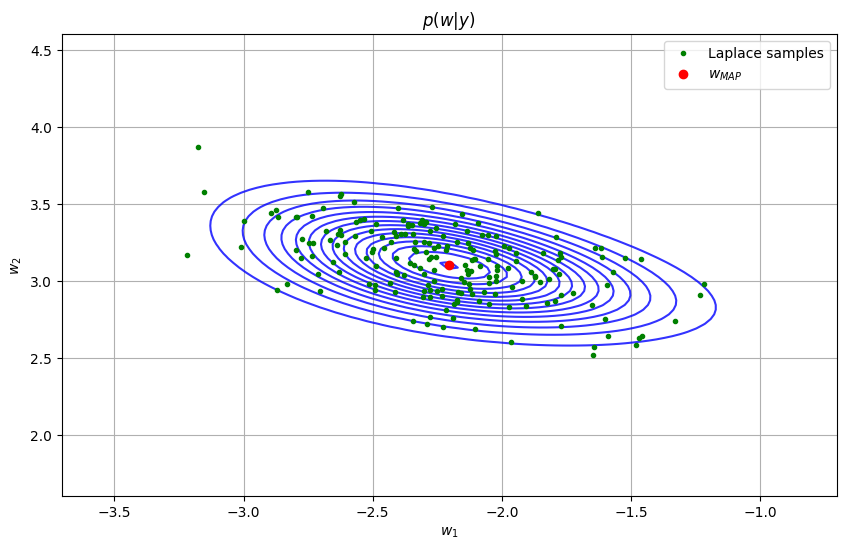

In [8]:
w_samples = L(200)  # 200 samples from the Laplace approximation
# w_samples = L_jacob(200)  # 200 samples from the Laplace approximation

padding = 1.5

dim1 = jnp.linspace(m[0] - padding, m[0] + padding, 100)
dim2 = jnp.linspace(m[1] - padding, m[1] + padding, 100)
grid_log_joint = Grid2D(dim1, dim2, log_joint, name='$p(w|y)$')

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
grid_log_joint.plot_contours(ax, f=jnp.exp, num_contours=15, alpha=0.8)
ax.plot(w_samples[:, 0], w_samples[:, 1], 'g.', label='Laplace samples')
ax.plot(m[0], m[1], 'ro', label='$w_{MAP}$')
ax.grid()
ax.legend()
plt.show()

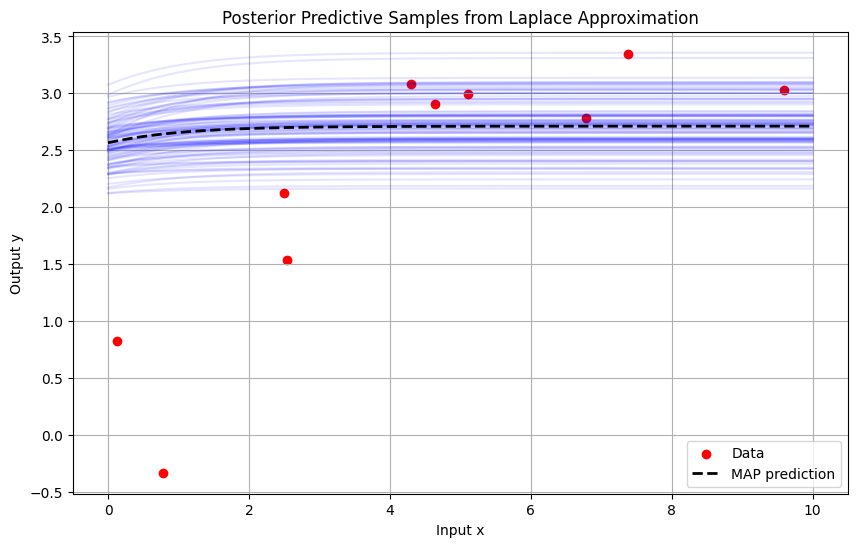

In [9]:
# Task 2.7
S = 100
x_grid = jnp.linspace(0, 10, 200)

# Draw samples from Laplace posterior q(w) = N(w_map, Σ)
key = random.PRNGKey(1)
w_samples = random.multivariate_normal(key, mean=w, cov=V, shape=(S,))

# Plot sampled functions
plt.figure(figsize=(10, 6))
for i in range(S):
    y_sample = f(x_grid, w_samples[i])
    plt.plot(x_grid, y_sample, color='blue', alpha=0.1)

# Overlay data and MAP prediction
plt.scatter(x, y, color='red', label='Data')
plt.plot(x_grid, f(x_grid, w), 'k--', label='MAP prediction', linewidth=2)
plt.title("Posterior Predictive Samples from Laplace Approximation")
plt.xlabel("Input x")
plt.ylabel("Output y")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
from scipy.stats import norm

# Task 2.8
# Compute the approximate posterior probability for the event f(8) > 3

def grad_f8(w):
    """
    Returns the gradient [d/dw0, d/dw1] of f(8) = w1 * sigmoid(8 + w0),
    evaluated at w = [w0, w1].
    """
    w0, w1 = w
    s = sigmoid(8.0 + w0)     # sigmoid(8 + w0)
    df_dw0 = w1 * s * (1.0 - s)
    df_dw1 = s
    return jnp.array([df_dw0, df_dw1])

# Evaluate f(8) at the MAP
f8_map = f(8, m)

# Gradient of f(8) at the MAP
g = grad_f8(m)

# Variance of f(8) under the Laplace approx (linearizing f(8))
var_f8 = g @ V @ g
std_f8 = jnp.sqrt(var_f8)

threshold = 3.0
# z-value for the event f(8) > threshold
z = (threshold - f8_map) / std_f8

# Probability that f(8) > threshold under the linearized Laplace approx
prob_linearized = 1.0 - norm.cdf(z)
print("Laplace linearization probability that f(8) > 3 is:", prob_linearized)

Laplace linearization probability that f(8) > 3 is: 0.662424288050011


In [ ]:
# Task 2.8 via monte carlo

# Compute the approximate posterior probability for the event f(8) > 3

# Increase number of samples for a more accurate estimate.
num_samples = 100000000
w_samples = L(num_samples)

# Define a vectorized function that computes f(8) for each sampled parameter w.
# Note: f = lambda x, w: w[1] * sigmoid(x + w[0]) is defined to operate on a single w.
# We use vmap to vectorize it over all samples.
from jax import vmap
f_at_8 = vmap(lambda w: w[1] * sigmoid(8 + w[0]))(w_samples)

# Compute the fraction of samples for which f(8) > 3.
posterior_prob = jnp.mean(f_at_8 > 3)
print("Approximate posterior probability for f(8) > 3:", posterior_prob.item())

Approximate posterior probability for f(8) > 3: 0.661543071269989
